In [1]:
import os
import logging
from datetime import datetime

log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"run_{timestamp}.log"
log_path = os.path.join(log_dir, log_filename)

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    handlers=[
        logging.StreamHandler(),               # Logs to stdout
        logging.FileHandler(log_path, mode='w')  # Logs to file with timestamp
    ]
)

In [2]:
from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage
from typing import Literal

In [3]:
from src.deep_research_workflow.models import Models
from src.deep_research_workflow.nodes import (
    QueryPlannerNode, 
    SubqueryGeneratorNode, 
    WebSearchNode,
    ReplannerNode,
    ReportWriterNode
)
from src.deep_research_workflow.data_structures import SearchState

OpenAIError: Missing credentials. Please pass one of `api_key`, `azure_ad_token`, `azure_ad_token_provider`, or the `AZURE_OPENAI_API_KEY` or `AZURE_OPENAI_AD_TOKEN` environment variables.

In [ ]:
def route_to_report_node(state)->Literal["replanner_node", "report_node"]:
    if state.max_tasks <= 0:
        return "report_node"
    if state.next_tasks:
        return "replanner_node"
    return "report_node"

In [ ]:
workflow = StateGraph(SearchState)

In [ ]:
workflow.add_node("planner_node", QueryPlannerNode())
workflow.add_node("subqueries_node", SubqueryGeneratorNode())
workflow.add_node(
    "websearch_node", 
    WebSearchNode(
        websearch_consolidation_llm=Models.gpt_4o,
        create_answer_llm=Models.gpt_4o
    )
)
workflow.add_node("replanner_node", ReplannerNode())
workflow.add_node("report_node", ReportWriterNode(llm=Models.gpt_4o))

2025-06-09 15:57:41,255 [INFO] src.deep_research_workflow.nodes: QueryPlannerNode initialized with client=<openai.resources.chat.completions.completions.Completions object at 0x7f5f532c9b50> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f5f52da6dd0> root_client=<openai.lib.azure.AzureOpenAI object at 0x7f5f532ac110> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x7f5f53353510> temperature=0.0 model_kwargs={} openai_api_key=SecretStr('**********') request_timeout=300.0 disabled_params={'parallel_tool_calls': None} azure_endpoint='https://expmig.openai.azure.com/' deployment_name='gpt-4o-mini' openai_api_version='2024-12-01-preview' openai_api_type='azure' model
2025-06-09 15:57:41,256 [INFO] src.deep_research_workflow.nodes: SubqueryGeneratorNode initialized with client=<openai.resources.chat.completions.completions.Completions object at 0x7f5f532c9b50> async_client=<openai.resources.chat.completions.completions.AsyncCompletio

In [ ]:
workflow.add_edge(START, "planner_node")
workflow.add_edge('planner_node', 'subqueries_node')
workflow.add_edge("subqueries_node", "websearch_node")
workflow.add_conditional_edges("websearch_node", route_to_report_node)
workflow.add_edge("replanner_node", "subqueries_node")
workflow.add_edge("report_node", END)

In [ ]:
graph = workflow.compile()

2025-06-09 15:57:41,299 [DEBUG] urllib3.connectionpool: Starting new HTTPS connection (1): mermaid.ink:443
2025-06-09 15:57:41,343 [DEBUG] urllib3.connectionpool: https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXBsYW5uZXJfbm9kZShwbGFubmVyX25vZGUpCglzdWJxdWVyaWVzX25vZGUoc3VicXVlcmllc19ub2RlKQoJd2Vic2VhcmNoX25vZGUod2Vic2VhcmNoX25vZGUpCglyZXBsYW5uZXJfbm9kZShyZXBsYW5uZXJfbm9kZSkKCXJlcG9ydF9ub2RlKHJlcG9ydF9ub2RlKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gcGxhbm5lcl9ub2RlOwoJcGxhbm5lcl9ub2RlIC0tPiBzdWJxdWVyaWVzX25vZGU7CglyZXBsYW5uZXJfbm9kZSAtLT4gc3VicXVlcmllc19ub2RlOwoJc3VicXVlcmllc19ub2RlIC0tPiB3ZWJzZWFyY2hfbm9kZTsKCXdlYnNlYXJjaF9ub2RlIC0uLT4gcmVwbGFubmVyX25vZGU7Cgl3ZWJzZWFyY2hfbm9kZSAtLi0+IHJlcG9ydF9ub2RlOwoJcmVwb3J0X25vZGUgLS0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0R

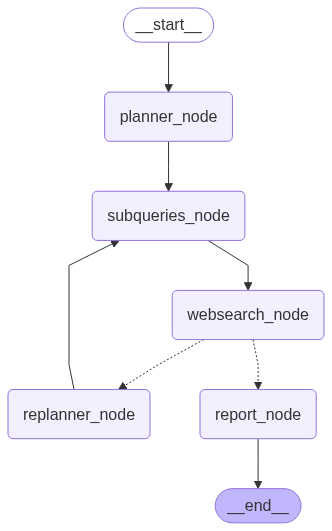

In [ ]:
from IPython.display import Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph(xray=True).draw_mermaid())

In [ ]:
import pprint
topic = """Rationale behind why LLM as a judge is effective, and what about evaluating text makes LLms suitable for evaluating Gen AI systems. Compare it with other more quantiative method and find me way to make Judge LLms have a more reliable qunatiative output"""
inputs = SearchState(
    query = topic,
    max_tasks = 10,
    max_subqueries = 3,
    max_query_results = 5,
    messages = [HumanMessage(content = topic)]
)

In [ ]:
output = graph.invoke(inputs, config={"recursion_limit": 100})

for key, value in output.items():
    pprint.pprint(f"Output from node '{key}':")
    pprint.pprint("---")
    pprint.pprint(value, indent=2, width=80, depth=None)

2025-06-09 16:20:03,534 [INFO] src.deep_research_workflow.nodes: QueryPlannerNode called with max_tasks=10
2025-06-09 16:20:03,535 [DEBUG] src.deep_research_workflow.nodes: Planning query for task 10 with history length 1
2025-06-09 16:20:03,537 [DEBUG] openai._base_client: Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Helper-Method': 'beta.chat.completions.parse', 'api-key': '<redacted>'}, 'files': None, 'idempotency_key': 'stainless-python-retry-c1c9850d-ffcc-4652-ae97-6f6a07560a43', 'post_parser': <function Completions.parse.<locals>.parser at 0x7f5f52d153a0>, 'json_data': {'messages': [{'content': 'You are an extremely experience web researcher.\n\n<Background Knowledge>\nThe current date is 2025-06-09\nTake this into account when assessing the query if relevant\n</Background Knowledge>\n\n<To Accomplish>\nYou are given a question by the user\nYou are to first think extensively extensively on the question, taking into account the backgroun

"Output from node 'max_tasks':"
'---'
0
"Output from node 'max_subqueries':"
'---'
3
"Output from node 'max_query_results':"
'---'
5
"Output from node 'query':"
'---'
('Rationale behind why LLM as a judge is effective, and what about evaluating '
 'text makes LLms suitable for evaluating Gen AI systems. Compare it with '
 'other more quantiative method and find me way to make Judge LLms have a more '
 'reliable qunatiative output')
"Output from node 'current_task':"
'---'
('Investigate the implications of using hybrid evaluation frameworks that '
 'combine qualitative assessments from LLMs with quantitative metrics in '
 'judicial decision-making, detailing their effectiveness in improving the '
 'accuracy and fairness of legal evaluations.')
"Output from node 'next_tasks':"
'---'
''
"Output from node 'current_subqueries':"
'---'
[ 'hybrid evaluation frameworks in judicial decision making',
  'impact of qualitative assessments from LLMs on legal evaluations',
  'effectiveness of combin

In [ ]:
from IPython.display import Markdown, display
display(Markdown(output['messages'][-1].content))

# Research Report: The Effectiveness of Large Language Models (LLMs) as Judges and Their Role in Evaluating Generative AI Systems

## Introduction

The integration of Large Language Models (LLMs) into judicial contexts and their application in evaluating Generative AI systems has garnered significant attention in recent years. This report explores the rationale behind using LLMs as judges, their effectiveness in evaluating Generative AI outputs, and the methodologies that enhance their reliability and reduce bias. Additionally, it compares qualitative assessments by LLMs with traditional quantitative methods, highlighting the strengths and weaknesses of each approach. Finally, it discusses hybrid evaluation frameworks that combine both qualitative and quantitative metrics, focusing on their implications for judicial decision-making.

## Rationale for Using LLMs as Judges

### 1. Efficiency and Speed
LLMs can process vast amounts of textual data quickly, which is particularly beneficial in legal contexts where time is often of the essence. They can generate summaries of complex legal documents, assist in case assessments, and provide preliminary judgments, thereby reducing the workload on human judges and expediting the judicial process ([1](https://www.linkedin.com/pulse/leveraging-large-language-models-llms-judges-emerging-aniket-mm2kf); [2](https://www.gerrishlegal.com/blog/ai-in-law-revolutionising-justice-or-raising-new-challenges)).

### 2. Consistency and Objectivity
Unlike human judges, who may be influenced by cognitive biases or emotional factors, LLMs can provide consistent evaluations based on predefined criteria. This objectivity can help mitigate human biases in judicial decision-making, ensuring that similar cases are treated similarly ([1](https://www.linkedin.com/pulse/leveraging-large-language-models-llms-judges-emerging-aniket-mm2kf); [2](https://www.gerrishlegal.com/blog/ai-in-law-revolutionising-justice-or-raising-new-challenges)).

### 3. Enhanced Legal Research and Document Review
LLMs can assist in legal research by quickly identifying relevant case law, statutes, and legal precedents. They can also streamline document review processes, helping legal professionals sift through extensive case files to find pertinent information ([2](https://www.gerrishlegal.com/blog/ai-in-law-revolutionising-justice-or-raising-new-challenges); [3](https://docket.acc.com/node/3940)).

### 4. Support in Judicial Decision-Making
Some jurisdictions have begun to explore the use of LLMs in judicial decision-making, where they can analyze case law and provide recommendations based on historical data. This capability can enhance the quality of legal reasoning and support judges in making informed decisions ([2](https://www.gerrishlegal.com/blog/ai-in-law-revolutionising-justice-or-raising-new-challenges); [3](https://docket.acc.com/node/3940)).

## Effectiveness of LLMs in Evaluating Generative AI Systems

### 1. Evaluating Creativity
LLMs have shown promise in evaluating creativity, particularly in creative writing tasks. A study demonstrated that LLMs could assess creative texts based on criteria such as fluency, flexibility, originality, elaboration, and usefulness. The results indicated that LLMs provided consistent evaluations, achieving higher Inter-Annotator Agreement (IAA) compared to human evaluators, although they struggled with recognizing nuanced, culturally specific aspects of creativity ([1](https://www.mdpi.com/2076-3417/15/6/2971)).

### 2. Assessing Coherence
LLMs can assess coherence through various metrics, including fluency and relevance. Studies have shown that LLMs can provide rapid and consistent evaluations of coherence, often outperforming traditional methods that rely solely on human judgment. However, challenges remain, as LLMs can produce outputs that sound fluent but may contain logical inconsistencies ([2](https://medium.com/@sumit.somanchd/testing-evaluating-large-language-models-llms-key-metrics-and-best-practices-part-2-0ac7092c9776)).

### 3. Evaluating Relevance
LLMs have demonstrated their ability to assess how closely generated text aligns with input prompts. Traditional evaluation methods often rely on exact matches, which can be limiting. In contrast, LLMs can evaluate relevance in a more nuanced manner, considering the context and intent behind the prompts ([3](https://www.techtarget.com/searchenterpriseai/tip/Compare-large-language-models-vs-generative-AI)).

## Comparison with Traditional Quantitative Methods

### Strengths of Qualitative Evaluations
1. **Nuanced Insights**: Qualitative evaluations provide in-depth feedback that captures the subtleties of model outputs, including identifying biases and assessing appropriateness ([4](https://arxiv.org/pdf/2411.17943)).
2. **Contextual Relevance**: These evaluations consider the context in which the AI operates, ensuring that outputs align with user expectations ([4](https://arxiv.org/pdf/2411.17943)).
3. **Identification of Limitations**: Qualitative methods can uncover limitations in model performance that quantitative metrics might miss ([4](https://arxiv.org/pdf/2411.17943)).

### Weaknesses of Quantitative Evaluations
1. **Limited Scope**: Quantitative metrics often focus on surface-level similarities, which may not reflect the true quality of generated content ([4](https://arxiv.org/pdf/2411.17943)).
2. **Context Ignorance**: These evaluations may fail to account for the specific context in which the AI operates ([4](https://arxiv.org/pdf/2411.17943)).
3. **Overfitting to Metrics**: There is a risk that models may be optimized to perform well on specific quantitative metrics rather than improving overall output quality ([4](https://arxiv.org/pdf/2411.17943)).

## Hybrid Evaluation Frameworks

### 1. Overview
Hybrid evaluation frameworks combine qualitative assessments from LLMs with quantitative metrics to provide a comprehensive evaluation of model performance. This dual approach allows for a more nuanced understanding of model outputs, addressing the limitations of relying solely on one type of evaluation ([5](https://wandb.ai/onlineinference/genai-research/reports/LLM-evaluation-Metrics-frameworks-and-best-practices--VmlldzoxMTMxNjQ4NA)).

### 2. Effectiveness in Improving Accuracy and Fairness
Hybrid frameworks enhance the accuracy of legal evaluations by identifying and mitigating errors in LLM outputs. They also address fairness concerns by incorporating fairness metrics alongside traditional performance metrics, ensuring that model predictions are consistent across different demographic groups ([6](https://www.datacamp.com/blog/llm-evaluation)).

### 3. Practical Applications
Case studies illustrate the successful implementation of hybrid evaluation frameworks in legal settings, enhancing the efficiency and accuracy of legal research. By employing hybrid evaluation methods, researchers have refined LLM outputs to align with legal standards and ethical considerations ([7](https://www.sciencedirect.com/org/science/article/pii/S1546221825004643)).

## Methodologies for Enhancing Reliability

### 1. Data Quality Assurance
Ensuring high-quality training data is crucial for improving the reliability of LLMs. Techniques such as data quality assurance and leveraging datasets from reputable sources can significantly enhance model performance ([8](https://www.secoda.co/blog/are-large-language-models-reliable-how-to-improve-accuracy)).

### 2. Knowledge Integration
Integrating domain-specific knowledge into LLMs enhances their contextual awareness, which is vital for legal applications. Utilizing knowledge graphs and embeddings allows LLMs to better understand legal terminology and context ([9](https://openreview.net/forum?id=jtM6timWBc)).

### 3. Continuous Monitoring
Implementing robust error detection mechanisms and continuous monitoring of LLM outputs ensures that any biases or inaccuracies are promptly addressed, enhancing the overall trustworthiness of the models ([8](https://www.secoda.co/blog/are-large-language-models-reliable-how-to-improve-accuracy)).

## Conclusion

The integration of LLMs as judges and their application in evaluating Generative AI systems presents a promising avenue for enhancing the efficiency, consistency, and accessibility of judicial processes. However, it is essential to navigate the associated challenges, particularly concerning bias, interpretability, and ethical implications. Hybrid evaluation frameworks that combine qualitative assessments with quantitative metrics can significantly improve the accuracy and fairness of legal evaluations, ensuring that LLMs serve as reliable tools in the judicial system.

### Sources
[1] Leveraging Large Language Models (LLMs) as Judges: An Emerging Concept. https://www.linkedin.com/pulse/leveraging-large-language-models-llms-judges-emerging-aniket-mm2kf  
[2] AI in Law: Revolutionising Justice or Raising New Challenges? https://www.gerrishlegal.com/blog/ai-in-law-revolutionising-justice-or-raising-new-challenges  
[3] Legal Tech: 5 Use Cases for Large Language Models in Legal Departments. https://docket.acc.com/node/3940  
[4] Evaluating Creativity: Can LLMs Be Good Evaluators in Creative Writing Tasks? https://www.mdpi.com/2076-3417/15/6/2971  
[5] LLM evaluation: Metrics, frameworks, and best practices | genai-research – Weights & Biases. https://wandb.ai/onlineinference/genai-research/reports/LLM-evaluation-Metrics-frameworks-and-best-practices--VmlldzoxMTMxNjQ4NA  
[6] LLM Evaluation: Metrics, Methodologies, Best Practices. https://www.datacamp.com/blog/llm-evaluation  
[7] A Hybrid Framework Combining Rule-Based and Deep Learning Approaches for Legal Document Analysis. https://www.sciencedirect.com/org/science/article/pii/S1546221825004643  
[8] Are Large Language Models Reliable? How To Improve Accuracy. https://www.secoda.co/blog/are-large-language-models-reliable-how-to-improve-accuracy  
[9] Equitable Access to Justice: Logical LLMs Show Promise. https://openreview.net/forum?id=jtM6timWBc  